In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

d:\programs\python3.7\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
d:\programs\python3.7\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\programs\python3.7\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data = pd.read_csv("data/train.csv", na_values=['#!', 'no data', 'NA'], index_col='id')
#X_test = pd.read_csv("data/test.csv", na_values=['#!', 'no data', 'NA'])
#macro = pd.read_csv("data/macro.csv", na_values=['#!', 'no data', 'NA'])
print(data.shape)
#print(macro.shape)

(30471, 291)


In [4]:
y = data['price_doc']
data.drop(['price_doc'], axis=1, inplace=True);

In [5]:
#data = pd.merge(data, macro, on='timestamp')
#data.shape

In [6]:
t = pd.to_datetime(data['timestamp'])
t = t.apply(lambda x: x.timestamp())
t = pd.Series(t.values)
data['timestamp'] = t

In [7]:
categorical_columns = [
    c for c in data.columns if data[c].dtype.name == 'object'
]
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object']

In [8]:
data = data.fillna(data.median(axis=0), axis=0)

In [9]:
data_describe = data.describe(include=[object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

In [10]:
binary_columns = [
    c for c in categorical_columns if data_describe[c]['unique'] == 2
]
nonbinary_columns = [
    c for c in categorical_columns if data_describe[c]['unique'] > 2
]
print(binary_columns, nonbinary_columns)

['product_type', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line'] ['sub_area', 'ecology']


In [11]:
for c in binary_columns:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1

In [12]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['sub_area_Ajeroport', 'sub_area_Akademicheskoe',
       'sub_area_Alekseevskoe', 'sub_area_Altuf'evskoe', 'sub_area_Arbat',
       'sub_area_Babushkinskoe', 'sub_area_Basmannoe', 'sub_area_Begovoe',
       'sub_area_Beskudnikovskoe', 'sub_area_Bibirevo',
       ...
       'sub_area_Vostochnoe Izmajlovo', 'sub_area_Vyhino-Zhulebino',
       'sub_area_Zamoskvorech'e', 'sub_area_Zapadnoe Degunino',
       'sub_area_Zjablikovo', 'sub_area_Zjuzino', 'ecology_excellent',
       'ecology_good', 'ecology_poor', 'ecology_satisfactory'],
      dtype='object', length=150)


In [13]:
data_numerical = data[numerical_columns]
data_numerical = (
    data_numerical - data_numerical.mean()) / data_numerical.std()

In [14]:
data = pd.concat((data_numerical, data[binary_columns], data_nonbinary),
                 axis=1)
data = pd.DataFrame(data)
print(data.shape)

(30471, 438)


In [15]:
print(data.shape)
print(y.shape)
N, d = data.shape
feature_names = data.columns

(30471, 438)
(30471,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.25, random_state=11)

N_train, _ = X_train.shape
N_test, _ = X_test.shape
print(N_train, N_test)
print(y_train.shape, y_test.shape)

22853 7618
(22853,) (7618,)


In [17]:
gbt = ensemble.GradientBoostingRegressor(n_estimators=100, random_state=11)
gbt.fit(X_train, y_train)
Y_pred = gbt.predict(X_test)
print("mean squared error:", (mse(y_test, Y_pred)))
print("score:", gbt.score(X_test, y_test))

mean squared error: 6694187751663.89
score: 0.7073254179900816


In [18]:
importances = gbt.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{}. feature '{}' ({})".format(f + 1, feature_names[idx],
                                         importances[idx]))

Feature importances:
1. feature 'full_sq' (0.27638346209175885)
2. feature 'timestamp' (0.03867299919421718)
3. feature 'floor' (0.036197137729180345)
4. feature 'state' (0.023226618012127873)
5. feature 'build_year' (0.019200324777824615)
6. feature 'max_floor' (0.018913088417289302)
7. feature 'ttk_km' (0.018096622730323947)
8. feature 'num_room' (0.01801165554831569)
9. feature 'water_km' (0.017522881848065303)
10. feature 'railroad_km' (0.017008699442564074)
11. feature 'kitch_sq' (0.01336553223758441)
12. feature 'life_sq' (0.013062641878651473)
13. feature 'indust_part' (0.012420177123607426)
14. feature 'hospital_beds_raion' (0.012202533150981347)
15. feature 'product_type' (0.011552568928971118)
16. feature 'cafe_count_5000_price_4000' (0.011480837414340566)
17. feature 'green_part_1000' (0.009433855961702941)
18. feature 'cemetery_km' (0.009407318176732191)
19. feature 'cafe_count_5000_price_2500' (0.00879744792110876)
20. feature 'cafe_count_3000' (0.008688529552343296)
21. f

(-1, 100)

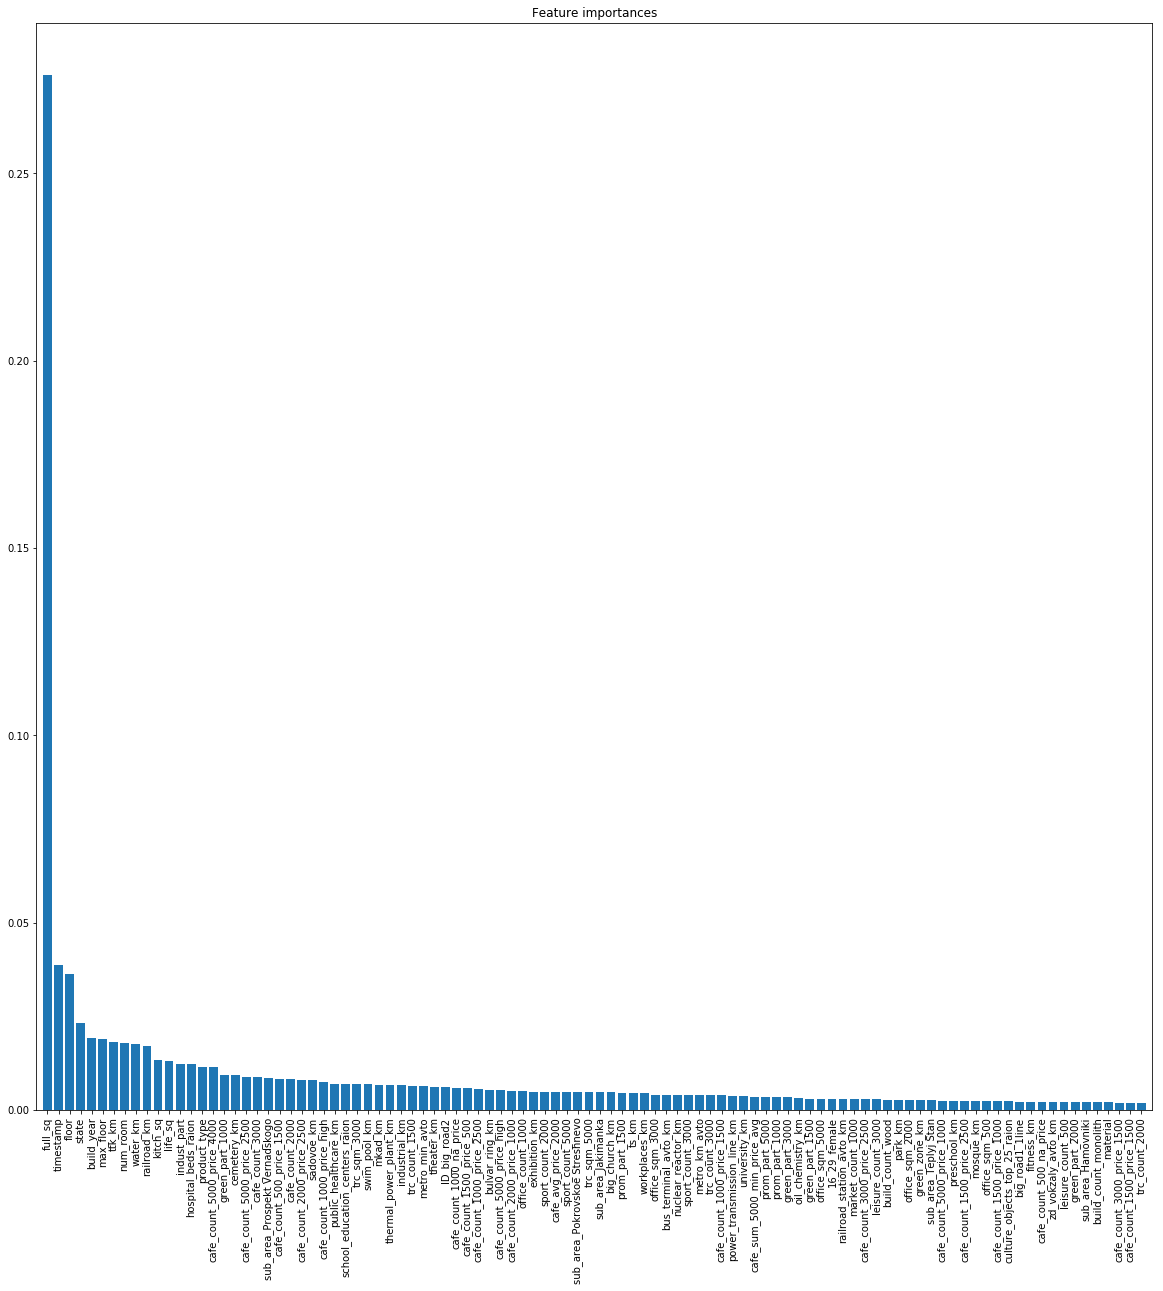

In [19]:
d_first = 100
plt.figure(figsize=(20, 20))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(
    range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])

In [20]:
best_features = indices[:164]
best_features_names = feature_names[best_features]
print(best_features_names)

Index(['full_sq', 'timestamp', 'floor', 'state', 'build_year', 'max_floor',
       'ttk_km', 'num_room', 'water_km', 'railroad_km',
       ...
       'office_km', 'cafe_count_3000_price_500', 'cafe_avg_price_3000',
       'prom_part_500', 'mosque_count_5000', 'metro_min_walk',
       'market_shop_km', 'ID_metro', 'university_top_20_raion',
       'market_count_500'],
      dtype='object', length=164)


In [21]:
gbt = ensemble.GradientBoostingRegressor(n_estimators=100, random_state=11)
gbt.fit(X_train[best_features_names], y_train)
Y_pred = gbt.predict(X_test[best_features_names])
print("mean squared error:", (mse(y_test, Y_pred)))
print("score:", gbt.score(X_test[best_features_names], y_test))

mean squared error: 6723496565077.728
score: 0.7060440161182907
